<a href="https://colab.research.google.com/github/JoungMinJu/lab_study/blob/main/Char_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical


In [5]:
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")
f = open('11-0.txt', 'rb')
lines=[]
for line in f: # 데이터를 한 줄씩 읽는다.
    line=line.strip() # strip()을 통해 \r, \n을 제거한다.
    line=line.lower() # 소문자화.
    line=line.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(line) > 0:
        lines.append(line)
f.close()

#간단한 전처리가 수행된 결과가 lines라는 리스트에 저장됨


In [10]:
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [11]:
#하나의 문자열로 통합
text=' '.join(lines)
print('문자열의 길이 또는 총 글자의 개수 : %d'%len(text))

문자열의 길이 또는 총 글자의 개수 : 159484


In [12]:
print(text[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


In [14]:
#문자열로부터 글자 집합을 만든다.
#기존엔 중복을 제거한 단어들의 모음인 단어 집합을 만들었으나 이번에 만들 집합은 글자 집합
char_vocab=sorted(list(set(text)))
vocab_size=len(char_vocab)
print("글자 집합의 크기 : {}".format(vocab_size))

#영어가 훈련 데이터일때 대부분의 경우에서 글자 집합의 크기가 단어 집합을 사용했을 경우보다 집합의 크기가 현저히 작다
#여어 단어를 표현하기 위해 글자 집합에 포함되는 글자는  26개의 알파벳 뿐이기 때문

#따라서 얼마나 양이 많더라도 집합의 크기를 적게 가져갈 수 있고 이는 구현과 테스트를 쉽게 할 수 있도록 한다
#따라서 RNN의 동작 메커니즘 이해를 위한 토이 프로젝트로 굉장히 많이 사용된다.



글자 집합의 크기 : 56


In [15]:
#글자집합에 인덱스를 부여하고 전부 출력해보기
char_to_index = dict((c, i) for i, c in enumerate(char_vocab)) # 글자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [16]:
#인덱스로부터 글자를 리턴하는
index_to_char={}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [ ]:
#훈련 데이터를 구성
#훈련 데이터에 apple이라는 시퀀스가 있고, 입력 시퀀스의 길이 즉 샘플의 길이를 4라고 한다면 
#입력시퀀스와 예측해야하는 출력 시퀀스는 다음과 같이 구성된다.

# Example) 샘플의 길이가 4라면 4개의 입력 글자 시퀀스로 부터 4개의 출력 글자 시퀀스를 예측. 즉, RNN의 time step은 4번
#appl -> pple
# appl은 train_X(입력 시퀀스), pple는 train_y(예측해야하는 시퀀스)에 저장한다.

In [17]:
#text문자열로부터 다수의 문장 샘플들로 분리
#분리 == 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전체를 등분한다.

seq_length = 60 # 문장의 길이를 60으로 한다.
n_samples = int(np.floor((len(text) - 1) / seq_length)) # 문자열을 60등분한다. 그러면 즉, 총 샘플의 개수
print ('문장 샘플의 수 : {}'.format(n_samples))

문장 샘플의 수 : 2658


In [18]:
train_X = []
train_y = []

for i in range(n_samples): # 2,646번 수행
    X_sample = text[i * seq_length: (i + 1) * seq_length]
    # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 가져온다.
    X_encoded = [char_to_index[c] for c in X_sample] # 하나의 문장 샘플에 대해서 정수 인코딩
    train_X.append(X_encoded)

    y_sample = text[i * seq_length + 1: (i + 1) * seq_length + 1] # 오른쪽으로 1칸 쉬프트한다.
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [19]:
print(train_X[0])

[49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]


In [20]:
print(train_y[0])

#y가 오른쪽으로 한 칸 쉬프트 됐음을 확인할 수 있다.

[37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]


In [21]:
#train_x와 train_y에 대해 원-핫 인코딩 수행
#글자단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩을 하지 않음
#긍까 임베딩 층을 사용하지 않을 것이므로 train_x에 대해서도 원-핫 인코딩을 한다.


In [22]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

In [24]:
print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

#샘플의 수 = 2,658
#입력 시퀀스의 길이=60
#각 벡터의 차원 =55

train_X의 크기(shape) : (2658, 60, 56)
train_y의 크기(shape) : (2658, 60, 56)


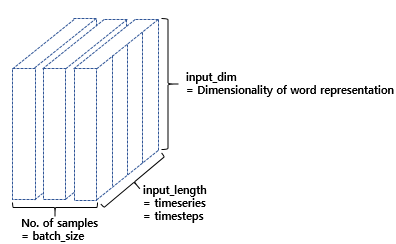

In [25]:
#모델 설계하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [26]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
84/84 - 43s - loss: 3.0683 - accuracy: 0.1822
Epoch 2/80
84/84 - 40s - loss: 2.7029 - accuracy: 0.2571
Epoch 3/80
84/84 - 39s - loss: 2.3717 - accuracy: 0.3339
Epoch 4/80
84/84 - 39s - loss: 2.2410 - accuracy: 0.3639
Epoch 5/80
84/84 - 39s - loss: 2.1442 - accuracy: 0.3872
Epoch 6/80
84/84 - 39s - loss: 2.0661 - accuracy: 0.4049
Epoch 7/80
84/84 - 39s - loss: 1.9984 - accuracy: 0.4238
Epoch 8/80
84/84 - 40s - loss: 1.9387 - accuracy: 0.4394
Epoch 9/80
84/84 - 39s - loss: 1.8862 - accuracy: 0.4547
Epoch 10/80
84/84 - 39s - loss: 1.8392 - accuracy: 0.4666
Epoch 11/80
84/84 - 39s - loss: 1.7920 - accuracy: 0.4808
Epoch 12/80
84/84 - 40s - loss: 1.7517 - accuracy: 0.4906
Epoch 13/80
84/84 - 40s - loss: 1.7126 - accuracy: 0.5002
Epoch 14/80
84/84 - 41s - loss: 1.6777 - accuracy: 0.5102
Epoch 15/80
84/84 - 41s - loss: 1.6408 - accuracy: 0.5189
Epoch 16/80
84/84 - 41s - loss: 1.6092 - accuracy: 0.5273
Epoch 17/80
84/84 - 41s - loss: 1.5802 - accuracy: 0.5349
Epoch 18/80
84/84 - 41s

In [28]:
def sentence_generation(model, length):
    ix = [np.random.randint(vocab_size)] # 글자에 대한 랜덤 인덱스 생성
    y_char = [index_to_char[ix[-1]]] # 랜덤 익덱스로부터 글자 생성
    print(ix[-1],'번 글자',y_char[-1],'로 예측을 시작!')
    X = np.zeros((1, length, vocab_size)) # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성

    for i in range(length):
        X[0][i][ix[-1]] = 1 # X[0][i][예측한 글자의 인덱스] = 1, 즉, 예측 글자를 다음 입력 시퀀스에 추가
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [29]:
sentence_generation(model, 100)

26 번 글자 ? 로 예측을 시작!
? she asked. yes, thats it, said the cat, alves a looking and under the united states and you are lo

'? she asked. yes, thats it, said the cat, alves a looking and under the united states and you are loc'

글자단위 RNN(CharRNN)으로 텍스트 생성하기

In [30]:
import numpy as np
from tensorflow.keras.utils import to_categorical

text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [32]:
#단락구분 없애고 하나의 문자열로 재저장
tokens=text.split()
text=' '.join(tokens)
print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [33]:
#글자 집합 만들겠습니다
char_vocab=sorted(list(set(text)))
print(char_vocab)

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [34]:
vocab_size=len(char_vocab)
print("글자 집합의 크기 : {}".format(vocab_size))

글자 집합의 크기 : 33


In [35]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab)) # 글자에 고유한 정수 인덱스 부여
print(char_to_index)


#이번에 만든 글자집합은 훈련 데이터에 등장한 알파벳의 대, 소문자를 구분하고 구두점과 공백을 포함



{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [36]:
#훈련에 사용할 문장 샘플을 만들것이다.
#여기서는 RNN을 이용해 생성한 텍스트 챕터와 유사하게 데이터를 구성하는데 다만, 단위가 글자단위다
#ex) 훈련데이터에 student라는 단어가 있고 입력 시퀀스의 길이가 5이면

# Example) 5개의 입력 글자 시퀀스로부터 다음 글자 시퀀스를 예측. 즉, RNN의 time step은 5번
#stude -> n 
#tuden -> t

In [37]:
#모든 샘플 길이가 11이되도록
length = 11
sequences = []
for i in range(length, len(text)):
    seq = text[i-length:i] # 길이 11의 문자열을 지속적으로 만든다.
    sequences.append(seq)
print('총 훈련 샘플의 수: %d' % len(sequences))

총 훈련 샘플의 수: 426


In [38]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [39]:
#전체 데이터에 대해 정수 인코딩
X = []
for line in sequences: # 전체 데이터에서 문장 샘플을 1개씩 꺼낸다.
    temp_X = [char_to_index[char] for char in line] # 문장 샘플에서 각 글자에 대해서 정수 인코딩을 수행.
    X.append(temp_X)

In [40]:
#정수인코딩 결과
for line in X[:5]:
    print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


In [41]:
#모든 샘플 문장에 대해서 맨 마지막 글자 분리
sequences = np.array(X)
X = sequences[:,:-1]
y = sequences[:,-1] # 맨 마지막 위치의 글자를 분리

In [42]:
sequences = [to_categorical(x, num_classes=vocab_size) for x in X] # X에 대한 원-핫 인코딩
X = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size) # y에 대한 원-핫 인코딩

In [43]:
print(X.shape)

(426, 10, 33)


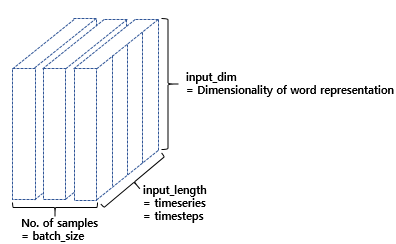

In [44]:
#모델 설계하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
model = Sequential()
model.add(LSTM(80, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

In [46]:
#LSTM을 사용하고 은닉상태 크기는 80 출ㄹ력층에 단어 집합의 크기만큼 뉴런을 배치하여 모델 설계


In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
14/14 - 2s - loss: 3.4550 - accuracy: 0.1737
Epoch 2/100
14/14 - 0s - loss: 3.2677 - accuracy: 0.1972
Epoch 3/100
14/14 - 0s - loss: 3.0324 - accuracy: 0.1972
Epoch 4/100
14/14 - 0s - loss: 2.9837 - accuracy: 0.1972
Epoch 5/100
14/14 - 0s - loss: 2.9568 - accuracy: 0.1972
Epoch 6/100
14/14 - 0s - loss: 2.9400 - accuracy: 0.1972
Epoch 7/100
14/14 - 0s - loss: 2.9142 - accuracy: 0.1972
Epoch 8/100
14/14 - 0s - loss: 2.8969 - accuracy: 0.1972
Epoch 9/100
14/14 - 0s - loss: 2.8729 - accuracy: 0.1972
Epoch 10/100
14/14 - 0s - loss: 2.8438 - accuracy: 0.1972
Epoch 11/100
14/14 - 0s - loss: 2.8074 - accuracy: 0.2066
Epoch 12/100
14/14 - 0s - loss: 2.7827 - accuracy: 0.2019
Epoch 13/100
14/14 - 0s - loss: 2.7527 - accuracy: 0.2347
Epoch 14/100
14/14 - 0s - loss: 2.7125 - accuracy: 0.2277
Epoch 15/100
14/14 - 0s - loss: 2.6583 - accuracy: 0.2394
Epoch 16/100
14/14 - 0s - loss: 2.6141 - accuracy: 0.2488
Epoch 17/100
14/14 - 0s - loss: 2.5718 - accuracy: 0.2723
Epoch 18/100
14/14 - 0s

In [48]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
# 모델, 인덱스 정보, 문장 길이, 초기 시퀀스, 반복 횟수
    init_text = seed_text # 문장 생성에 사용할 초기 시퀀스
    sentence = ''

    for _ in range(n): # n번 반복
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))
        result = model.predict_classes(encoded, verbose=0)
        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 글자)를 result에 저장.
        for char, index in char_to_index.items(): # 만약 예측한 글자와 인덱스와 동일한 글자가 있다면
            if index == result: # 해당 글자가 예측 글자이므로 break
                break
        seed_text=seed_text + char # 현재 시퀀스 + 예측 글자를 현재 시퀀스로 변경
        sentence=sentence + char # 예측 글자를 문장에 저장
        # for문이므로 이 작업을 다시 반복

    sentence = init_text + sentence
    return sentence
  
  #문장을 생성하는 함수
  

In [49]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I get on with life as a programmer, I like to contemplate beer. But when I stop my talking
